In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# サンプルデータの準備
seq_length = 20
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1))  # (21, 1)の形状にリサイズ

# データをテンソルに変換
x = data[:-1]  # 入力系列
y = data[1:]   # 出力系列

x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # 入力系列をテンソルに変換
y = torch.tensor(y, dtype=torch.float32)            # 出力系列をテンソルに変換

print(x.shape,y.shape)
# LSTMモデルの定義
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ハイパーパラメータ
input_size = 1   # 入力の次元
hidden_size = 32 # LSTMの隠れ層の次元
output_size = 1  # 出力の次元
num_layers = 2   # LSTMのレイヤー数
num_epochs = 100
learning_rate = 0.01

# モデル、損失関数、オプティマイザの定義
model = LSTM(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# モデルのトレーニング
for epoch in range(num_epochs):
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




torch.Size([20, 1, 1]) torch.Size([20, 1])
Epoch [10/100], Loss: 0.1354
Epoch [20/100], Loss: 0.0740
Epoch [30/100], Loss: 0.0760
Epoch [40/100], Loss: 0.0575
Epoch [50/100], Loss: 0.0363
Epoch [60/100], Loss: 0.0166
Epoch [70/100], Loss: 0.0122
Epoch [80/100], Loss: 0.0122
Epoch [90/100], Loss: 0.0114
Epoch [100/100], Loss: 0.0115


In [2]:
model.state_dict().keys()

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])

In [5]:
model.lstm.weight_ih_l0.shape

torch.Size([128, 1])

In [6]:
model.lstm.weight_hh_l0.shape

torch.Size([128, 32])

In [4]:
model.lstm.bias_ih_l0.unsqueeze(1).shape

torch.Size([128, 1])

In [7]:
model.lstm.bias_hh_l0.unsqueeze(1).shape

torch.Size([128, 1])

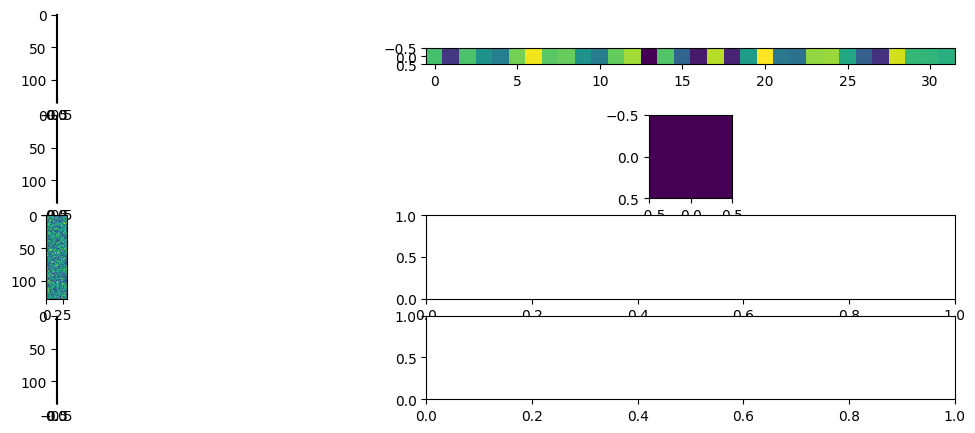

In [2]:
from vismodel.visualize import visualize_wandb

visualize_wandb(model)

In [ ]:
# モデルの評価
model.eval()
with torch.no_grad():
    future = 50
    pred = torch.zeros(seq_length + future, 1)

    print(pred.shape,x.shape)
    pred[:seq_length] = x.view(-1)

    for i in range(seq_length, seq_length + future):
        pred[i] = model(pred[i-seq_length:i].view(1, seq_length, 1))

    plt.plot(time_steps, data, 'b-', label='Actual')
    plt.plot(time_steps, pred.numpy(), 'r-', label='Predicted')
    plt.legend()
    plt.show()